In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# https://www.kaggle.com/code/sombersomni/finetuned-resnet-classifier-in-pytorch-97

In [165]:
root_path = 'kaggle/10BigCats'
wildcats_data = pd.read_csv(f'{root_path}/WILDCATS.CSV')
# 只看前五個
wildcats_data.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


In [166]:
import torch
torch.manual_seed(888)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [167]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

class WildCatDataset(Dataset):
    def __init__(self, data, transform=None, data_augmentation=False):
        # index 欄位丟掉
        self.data = data.reset_index(drop=True)
        self.transform = transform
        self.initial_transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
        # mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.224], 是由imagenet 訓練集中抽樣計算出來的
        input_transforms = [
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )]+([transforms.RandomHorizontalFlip()] if data_augmentation else [])

        self.input_transform = transforms.Compose(input_transforms)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 分類編號
        class_id = self.data.loc[idx, 'class id']
        # 檔案位置
        file_path = self.data.loc[idx, 'filepaths']
        name = self.data.loc[idx, 'labels']
        # 打開圖像轉成 tensor
        full_path = os.path.join(root_path, file_path)
        with Image.open(full_path) as img:
            img = self.initial_transform(img)
            # 旋轉圖像，因為它們最初都是逆時針翻轉 90 度
            img = transforms.functional.rotate(img, 90)

        if self.transform:
            img = self.transform(img)
        # 正規化
        img_input = self.input_transform(img.float())
        img = img.transpose(2,0).detach().numpy()
        sample ={'targets':class_id, 'inputs': img_input, 'images':img, 'names': name}
        return sample



In [168]:
# Let's separate each data set
train_data = wildcats_data[wildcats_data['data set'] == 'train']
test_data = wildcats_data[wildcats_data['data set'] == 'test']
valid_data = wildcats_data[wildcats_data['data set'] == 'valid']
len(train_data), len(test_data), len(valid_data)

(2339, 50, 50)

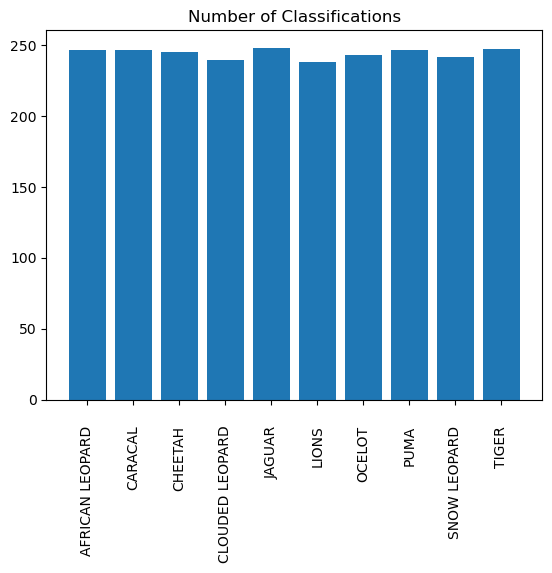

In [169]:
scientific_names = wildcats_data.groupby('labels').size().to_dict().items()
plt.bar([name for name, _ in scientific_names], [count for _, count in scientific_names])
plt.tick_params(axis='x', which='major', pad=15, labelrotation=90)
plt.title('Number of Classifications')
plt.show()


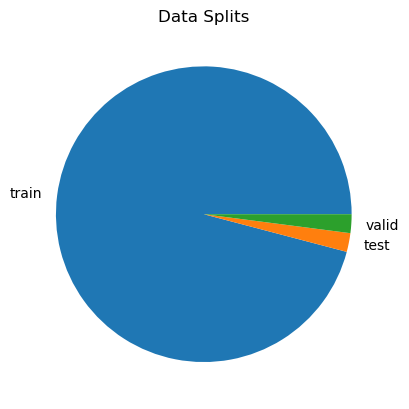

train_data.shape: (2339, 5)


In [170]:
labels = ['train', 'test', 'valid']
plt.title('Data Splits')
plt.pie([train_data.shape[0], test_data.shape[0], valid_data.shape[0]], labels=labels)
plt.show()

# 有幾筆資料, 一筆資料有幾個欄位
print(f'train_data.shape: {train_data.shape}')

In [171]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(WildCatDataset(train_data, data_augmentation=True), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(WildCatDataset(test_data), batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(WildCatDataset(valid_data), batch_size=batch_size, shuffle=False)

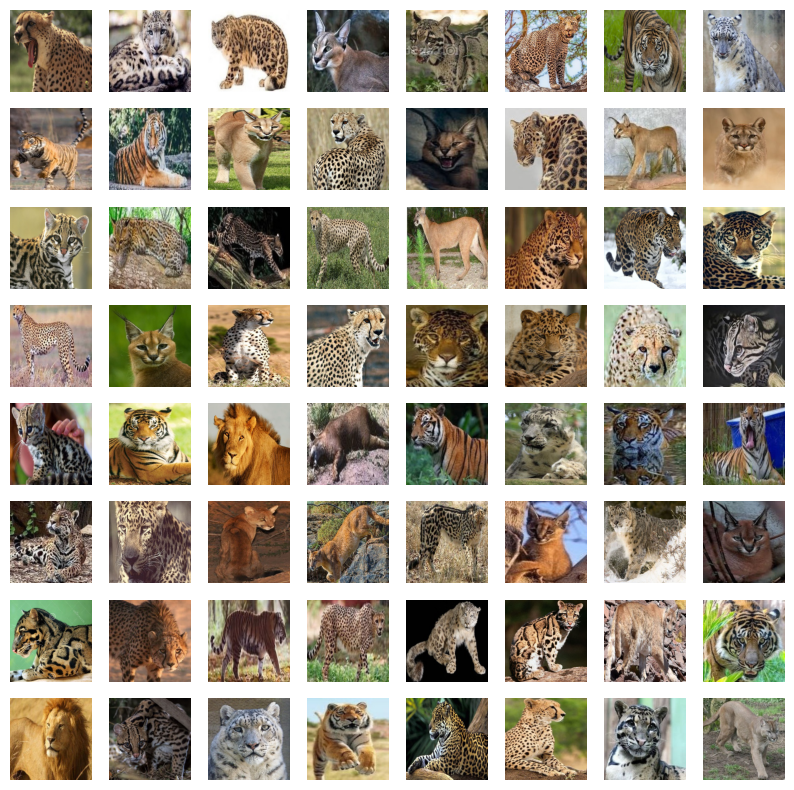

In [172]:
# 簡單觀看圖片資料
single_batch = next(iter(train_dataloader))
# 建立子圖表 8*8
fig, axes = plt.subplots(batch_size // 8, 8, figsize=(10,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(single_batch['images'][i])
    ax.set_axis_off()

In [173]:
from torchvision import models
# Let's now setup the model
# We will use the pretrained Resnet100


class Model(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        
        # Load the ResNet model
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        # I removed this because I get better results fine tuning the model
#         for param in resnet.parameters():
#             param.requires_grad = False
        
        # Reconstruct the model without the last layer
        self.net = torch.nn.Sequential(*list(resnet.children())[:-1])
        # Build fully connected layers to handle predictions
        self.fcs = torch.nn.Sequential(
            torch.nn.Linear(2048, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, num_classes)
        )
        
    def forward(self, x):
        # Pass the input through the ResNext model
        x = self.net(x)
        # Flatten the output of ResNet
        x = x.view(x.shape[0], -1)
        # Send to fully connected layer
        return self.fcs(x)

In [174]:
from abc import ABC, abstractmethod

# Create a Plotable interface for hooks that will use plotting
class Plotable(ABC):
    @abstractmethod
    def plot(self, **kwargs):
        raise NotImplemented('Please implement your plot() method')

# Create a generic Hook class as our Base class for other hooks
class Hook:
    def __init__(self, model):
        self.hooks = []
        for layer in model.modules():
            # we save the returned hook to remove later
            hook = layer.register_forward_hook(self.run)
            self.hooks.append(hook)   
    def run(self, module, t_input, t_output):
        raise NotImplemented('Please implement your hook run() method')
    def __enter__(self):
        return self
    def __exit__(self, exception_type, exception_value, exception_traceback):
        del self
    def remove(self):
        for hook in self.hooks:
            hook.remove()
    def __del__(self):
        self.remove()

In [175]:
# Register hooks to save all image outputs from every convolutional layer
class ConvHook(Hook, Plotable):
    def __init__(self, model):
        super(ConvHook, self).__init__(model)
        self.outputs = []
    def run(self, module, t_input, t_output):
        if isinstance(module, torch.nn.Conv2d):
            self.outputs.append(t_output)
    def plot(self, **kwargs):
        # If outputs length not suitable for grid, exit function
        limit = kwargs.get('limit', 99)
        outputs = self.outputs[:limit]
        size = (limit + 1) ** 0.5 
        if size % 1 != 0:
            return
        # plot all outputs
        fig, axes = plt.subplots(int(size), int(size), figsize=(int(size) + 2, int(size) + 2))
        axes = axes.flatten()
        img = kwargs.get('initial_image')
        if img is None:
            axes[0].set_axis_off()
        else:
            axes[0].imshow(img)
        for i, output in enumerate(outputs, 1):
            axes[i].imshow(output[0].transpose(2,0).cpu().detach().numpy()[:,:,:3])
            axes[i].set_axis_off()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

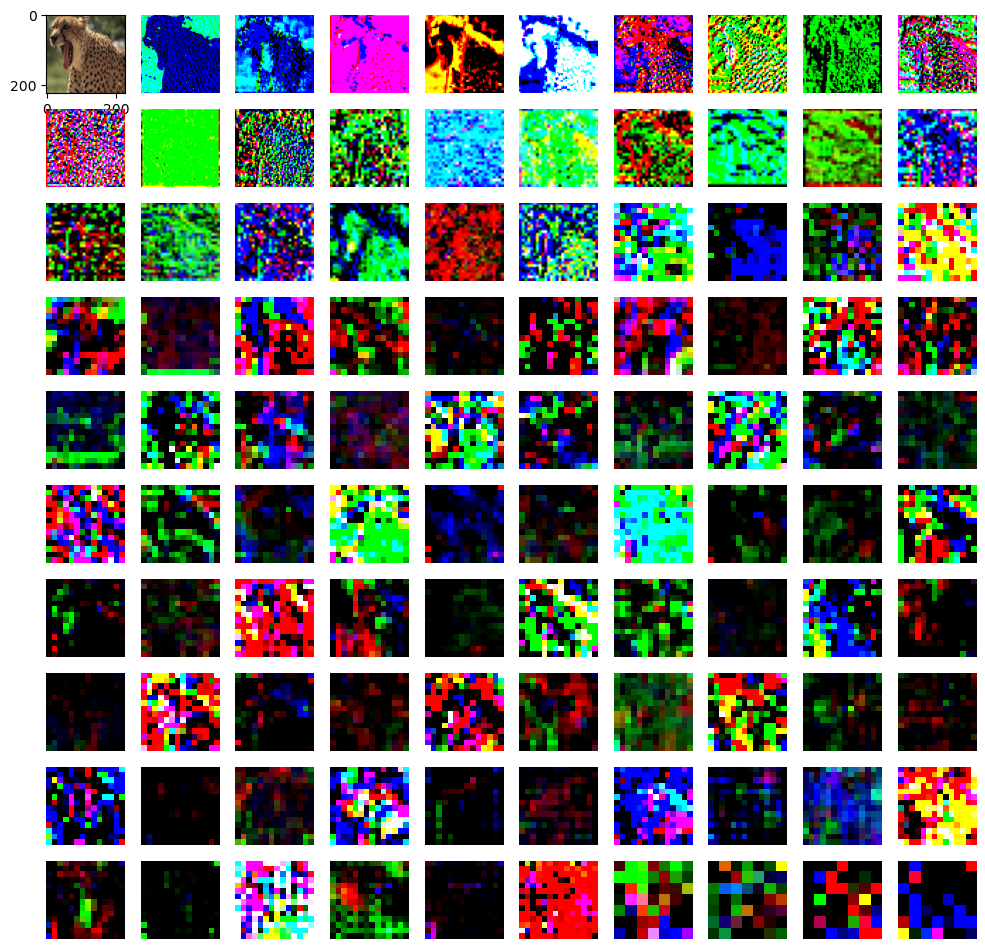

In [176]:
with torch.inference_mode():
    model = Model()
    with ConvHook(model) as hook:
        img = single_batch['images'][0]
        img_input = single_batch['inputs'][0]
        img_input = img_input.view(1, *img_input.shape)
        model.net(img_input)
        hook.plot(initial_image=img)

訓練
我們創建了一個訓練函數來處理迭代過程。 我們接受一個數據加載器並簡單地遍歷每個批次。 注意 float() 調用。 因為包裝輸入和目標張量的張量最初設置為數據類型 uint8，所以我們必須將它們轉換為浮點型和長型張量。 然後我們走正常的pytorch訓練流程。 一旦我們計算了損失並預測了一個類別，我們就會計算統計數據以供以後的數據分析。

In [177]:
# Setup training
def train(model, criterion, optimizer, dataloader, device='cpu', num_epochs=1):
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0.0
        correct = 0.0
        for i, data in enumerate(dataloader):
            # Get the inputs and move them to the device
            inputs, targets = data['inputs'].float(), data['targets'].long()
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            # Get prediction for accuracy
            _, predicted = torch.max(outputs, axis=1)
            # Calculate stats
            running_loss += loss.item()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
             # Print statistics
            if i % 10 == 0 and i > 0:    # Print every 100 mini-batches
                print('[epoch: %d, batch: %5d] loss: %.3f' % (epoch + 1, i + 1 + i % 10, running_loss / 100))
                print('Accuracy of the model on the %d images: %.2f %%' % (total, 100 * correct / total))
                loss_history.append(running_loss / 100)
                accuracy_history.append(100 * correct / total)
                running_loss = 0.0
                total = 0.0
                correct = 0.0
    return {"loss_history": loss_history, "accuracy_history": accuracy_history}

我們正在創建一個 ActivationHook 來跟踪激活層的均值和標準差。 為此，我們只跟踪全連接層中的單個 ReLU。 但是，我們也可以跟踪整個 ResNet。 我們可以安全地假設這些層的權重相對穩定。 我們只想跟踪我們網絡的穩定性。

In [178]:
from collections import namedtuple
# Create a namedtuple to help know where our mean and standard deviation sit
Activation = namedtuple('Activation', 'mean std')
# Here we track the mean and standard deviation for the ReLU layer in our fully connected layer
class ActivationHook(Hook, Plotable):
    def __init__(self, model):
        super(ActivationHook, self).__init__(model.fcs)
        self.outputs = {}

    def run(self, module, t_input, t_output):
        if isinstance(module, torch.nn.ReLU):
            with torch.no_grad():
                mean = t_output.mean().item()
                std = t_output.std().item()
                activation = Activation(mean, std)
                key = module
                if module in self.outputs:
                    self.outputs[key].append(activation)
                else:
                    self.outputs[key] = [activation]

    def plot(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes = axes.flatten()
        for name, output in self.outputs.items():
            x = np.arange(len(output))
            means = [mean for mean, _ in output]
            stds = [std for _, std in output]
            axes[0].stem(x, means)
            axes[0].set_ylim(0,1)
            axes[0].set_title('Activation Mean')
            axes[0].set_ylabel('mean')
            axes[0].set_xlabel('iterations')
            axes[1].stem(x, stds)
            axes[1].set_ylim(0,1)
            axes[1].set_title('Activation Standard Deviation')
            axes[1].set_ylabel('std')
            axes[1].set_xlabel('iterations')
        plt.show()

In [179]:
# 找死掉的權重
# Create a namedtuple to track the weights and bias zero count
DeadWeight = namedtuple('DeadWeight', 'weight bias')
# Here we track the average count of zeroes in our weights and biases for our fully connected layer
class DeadWeightHook(Hook, Plotable):
    def __init__(self, model):
        super(DeadWeightHook, self).__init__(model.fcs)
        self.outputs = []

    def run(self, module, t_input, t_output):
        if isinstance(module, torch.nn.Linear):
            with torch.no_grad():
                # Take the count of zeros over weights and biases and calculate percentage
                zero_weight = len(module.weight[(module.weight < 10 ** -8) & (module.weight > -10 ** -8)])
                zero_bias = len(module.bias[(module.bias < 10 ** -8) & (module.bias > -10 ** -8)])
                deadweight = DeadWeight(zero_weight / len(module.weight.view(-1)), zero_bias / len(module.bias))
                self.outputs.append(deadweight)
                
    def plot(self, **kwargs):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes = axes.flatten()
        weights = [weight for weight, _ in self.outputs]
        biases = [bias for _, bias in self.outputs]
        x = np.arange(len(self.outputs))
        axes[0].plot(x, weights)
        axes[0].set_ylim(-1, 1)
        axes[0].set_title('Zero Weight Count')
        axes[0].set_ylabel('count')
        axes[0].set_xlabel('iterations')
        axes[1].plot(x, biases)
        axes[1].set_ylim(-1, 1)
        axes[1].set_title('Zero Bias Count')
        axes[1].set_ylabel('count')
        axes[1].set_xlabel('iterations')
        plt.show()

In [180]:
# Setup training variables
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0
num_classes = len(wildcats_data['class id'].unique())
num_epochs = 5

model = Model(num_classes).to(device)
# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

測試
達到最低限度並不需要很長時間。 大約 4 個時期後，我們達到最小損失。 我讓它運行到 6，但是再運行訓練可能會導致過度擬合。

基於激活方式和標準差，我們可以安全地假設我們的網絡是穩定的。 如果均值和標準差發生顯著變化，我們將需要重新設計我們的網絡並嘗試在不同層中引入一些歸一化。 由於我對輸入進行了歸一化並使用了批量歸一化 (BatchNorm1d)，因此我們權重中的所有數字似乎都保持在設定範圍內！

使用 DeadWeightHook 表明我們的權重中幾乎沒有零值。 這意味著我們的神經元是活躍的並且在工作。 如果你有大量死神經元，你會想回到你的網絡並檢查你的權重初始化、輸入或權重歸一化。

[epoch: 1, batch:    11] loss: 0.174
Accuracy of the model on the 704 images: 46.73 %
[epoch: 1, batch:    21] loss: 0.060
Accuracy of the model on the 640 images: 79.69 %
[epoch: 1, batch:    31] loss: 0.032
Accuracy of the model on the 640 images: 90.16 %
[epoch: 2, batch:    11] loss: 0.027
Accuracy of the model on the 704 images: 92.33 %
[epoch: 2, batch:    21] loss: 0.011
Accuracy of the model on the 640 images: 96.72 %
[epoch: 2, batch:    31] loss: 0.016
Accuracy of the model on the 640 images: 96.25 %
[epoch: 3, batch:    11] loss: 0.005
Accuracy of the model on the 704 images: 98.58 %
[epoch: 3, batch:    21] loss: 0.006
Accuracy of the model on the 640 images: 97.97 %
[epoch: 3, batch:    31] loss: 0.006
Accuracy of the model on the 640 images: 98.28 %
[epoch: 4, batch:    11] loss: 0.003
Accuracy of the model on the 704 images: 99.43 %
[epoch: 4, batch:    21] loss: 0.003
Accuracy of the model on the 640 images: 99.22 %
[epoch: 4, batch:    31] loss: 0.005
Accuracy of the m

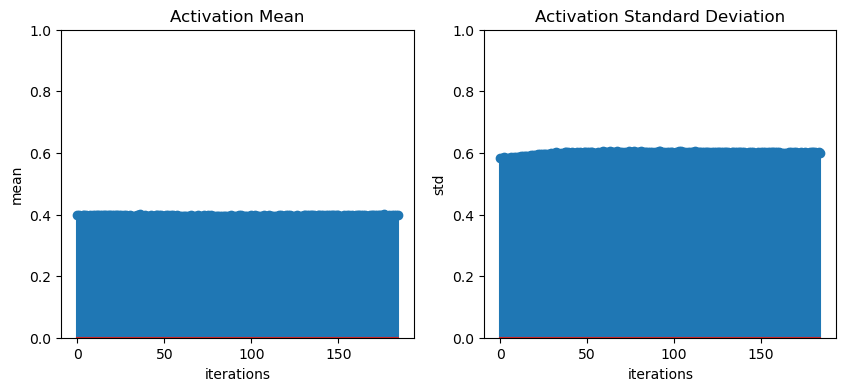

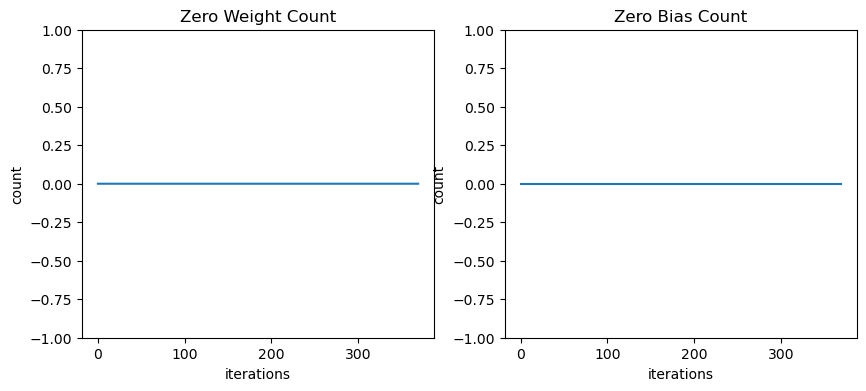

In [181]:
with ActivationHook(model) as activation_hook, DeadWeightHook(model) as dead_weight_hook:
    history = train(model, criterion, optimizer, train_dataloader, device=device, num_epochs=num_epochs)
    activation_hook.plot()
    dead_weight_hook.plot()

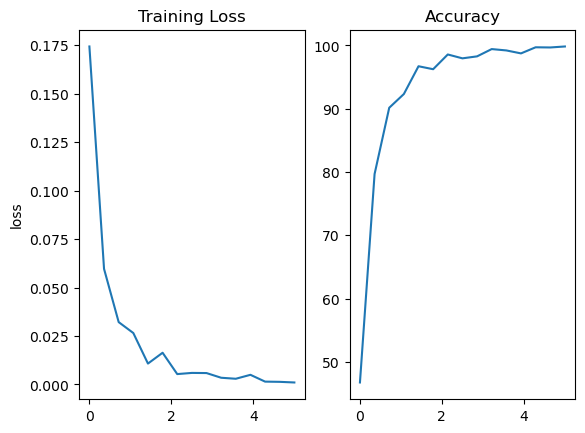

In [182]:
ax = plt.subplot(1,2,1)
ax.plot(np.linspace(0, num_epochs, len(history['loss_history'])), history['loss_history'])
ax.set_title('Training Loss')
ax.set_ylabel('loss')
ax = plt.subplot(1,2,2)
ax.plot(np.linspace(0, num_epochs, len(history['accuracy_history'])), history['accuracy_history'])
ax.set_title('Accuracy')
plt.show()

In [183]:
def evaluate(model, dataloader):
    with torch.inference_mode():
        total, correct = 0, 0
        for data in dataloader:
            # Get the inputs and move them to the device
            inputs, targets = data['inputs'].float(), data['targets'].long()
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, axis=1)

            # Record the accuracy
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Print the accuracy
    print('Accuracy of the model on the %d images: %.2f %%' % (total, 100 * correct / total))

In [184]:
# Evaluate test data
print('Test Case')
evaluate(model, test_dataloader)

print('Valid Case')
# Evaluate valid data
evaluate(model, valid_dataloader)

Test Case
Accuracy of the model on the 50 images: 98.00 %
Valid Case
Accuracy of the model on the 50 images: 98.00 %


混淆矩陣
為了查看我們是否有任何假陽性或假陰性，我們使用混淆矩陣。 這為我們提供了準確性的直觀表示。 好像有一次豹貓和雲豹搞混了。 雖然它並不完美，但儘管有微小的錯誤分類，但它的準確度還是很高的。

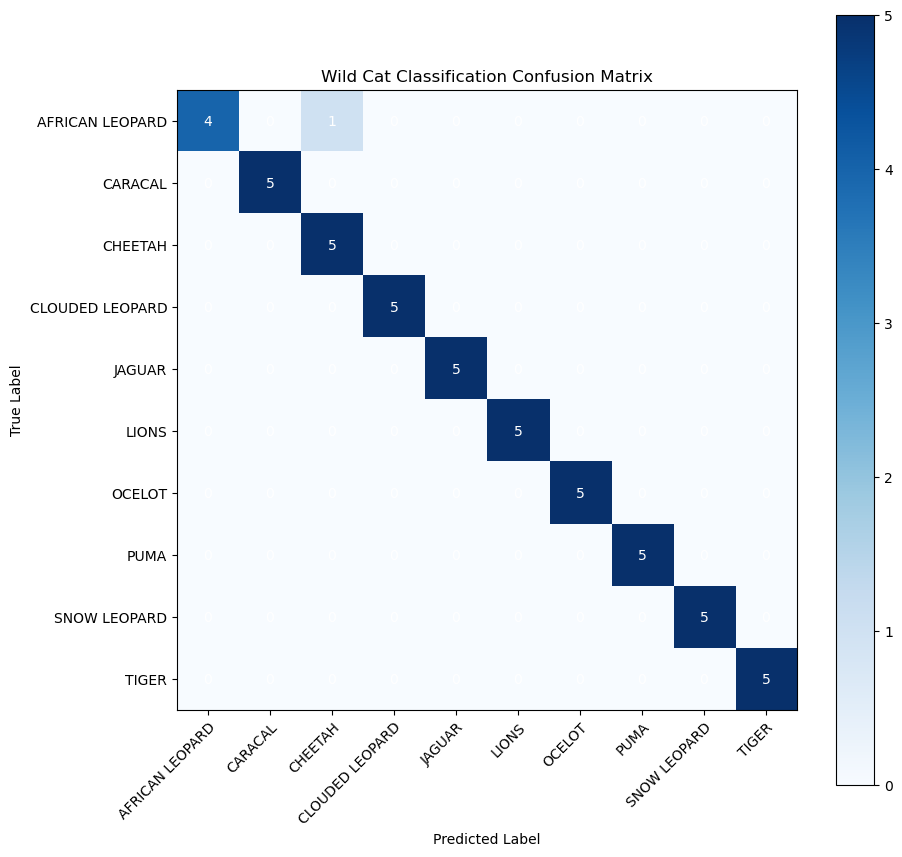

In [186]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes=10).to(device)
with torch.inference_mode():
    valid_batch = next(iter(valid_dataloader))
    inputs, targets, class_names = (
        valid_batch['inputs'].float(),
        valid_batch['targets'].long(),
        valid_data['labels'].unique()
    )
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, axis=1)
    confusion_matrix = confmat(pred, targets)

    # Plot the confusion matrix using imshow
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(confusion_matrix.cpu().detach(), cmap='Blues')

    # Set the tick labels to the class names
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the x tick labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Loop over the data and annotate the plot with the values
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusion_matrix[i, j].item(),
                           ha="center", va="center", color="white")

    # Set the title and labels
    ax.set_title("Wild Cat Classification Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()

In [187]:
torch.save(model.state_dict(), f"checkpoints/10BigCats_v01.pth")
print('模型已保存')

模型已保存
